#  Data Preprocessing

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset (adjust the file path as needed)
data = pd.read_pickle('../data/processed/df_loan.pkl').sample(frac=0.1, random_state=42)

# Separate features and target
X = data.drop(['Risk_Flag', 'Id'], axis=1)
y = data['Risk_Flag']

# Identify numerical and categorical features
num_features = ['Income', 'Age', 'Experience', 'CURRENT_HOUSE_YRS']
cat_features = ['Married/Single', 'House_Ownership', 'Car_Ownership', 
                'Profession', 'CITY', 'STATE']

# Preprocessing pipeline for numerical features: imputation and scaling.
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features: imputation and one-hot encoding.
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Example: Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)


# Pipelines

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

# Define a dictionary to hold pipelines and parameter grids for each model.
models = {
    'KNN': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', KNeighborsClassifier())]),
        'params': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    'RandomForest': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', RandomForestClassifier(random_state=42))]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_split': [2, 5]
        }
    },
    'ExtraTrees': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', ExtraTreesClassifier(random_state=42))]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 5, 10],
        }
    },
    'LogisticRegression': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', LogisticRegression(solver='liblinear'))]),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2']
        }
    },
    'SVM': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', SVC(probability=True))]),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['rbf', 'linear']
        }
    },
    'GradientBoosting': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', GradientBoostingClassifier(random_state=42))]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [3, 5]
        }
    },
    'LightGBM': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', LGBMClassifier(random_state=42))]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [3, 5]
        }
    },
    # 'CatBoost': {
    #     'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
    #                                   # Setting verbose=0 to avoid too much logging during tuning.
    #                                   ('classifier', CatBoostClassifier(verbose=0, random_state=42))]),
    #     'params': {
    #         'classifier__iterations': [100, 200],
    #         'classifier__learning_rate': [0.01, 0.1],
    #         'classifier__depth': [3, 5]
    #     }
    # },
    'NeuralNetwork': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', MLPClassifier(max_iter=500, random_state=42))]),
        'params': {
            'classifier__hidden_layer_sizes': [(50,), (100,)],
            'classifier__activation': ['relu', 'tanh'],
            'classifier__alpha': [0.0001, 0.001]
        }
    }
}


# Hyperparameter Tuning and Cross-Validation

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer
import numpy as np
import time

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define scoring metrics with the correct positive label
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label='High Risk'),
    'recall': make_scorer(recall_score, pos_label='High Risk'),
    'f1': make_scorer(f1_score, pos_label='High Risk'),
    'roc_auc': 'roc_auc'  # Using built-in string format instead of make_scorer with needs_proba
}

results = {}
best_models = {}

for model_name, model_info in models.items():
    print(f"Processing {model_name}...")
    start_time = time.time()
    
    try:
        # Initialize GridSearchCV with n_jobs=1 to avoid parallelization issues
        grid = GridSearchCV(estimator=model_info['pipeline'],
                            param_grid=model_info['params'],
                            scoring=scoring,
                            refit='roc_auc',   # Using AUC as the primary metric for refitting
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                            n_jobs=1)  # Changed from -1 to 1 to avoid multiprocessing issues
        
        # Fit on training data
        grid.fit(X_train, y_train)
        
        # Save best model and best parameters
        best_models[model_name] = grid.best_estimator_
        print(f"Best parameters for {model_name}: {grid.best_params_}")
        
        # Evaluate on test set
        y_pred = grid.predict(X_test)
        y_prob = grid.predict_proba(X_test)[:, 1]  # Assuming 'High Risk' is the second class
        
        # Check class ordering in the classifier to get the correct probability column
        classes = grid.best_estimator_.classes_
        high_risk_idx = np.where(classes == 'High Risk')[0][0]
        y_prob = grid.predict_proba(X_test)[:, high_risk_idx]
        
        model_results = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, pos_label='High Risk'),
            'recall': recall_score(y_test, y_pred, pos_label='High Risk'),
            'f1': f1_score(y_test, y_pred, pos_label='High Risk'),
            'roc_auc': roc_auc_score(y_test, y_prob),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        results[model_name] = model_results
        print(f"Completed {model_name} in {time.time() - start_time:.2f} seconds")
        print(f"ROC-AUC: {model_results['roc_auc']:.3f}, F1: {model_results['f1']:.3f}")
        
    except Exception as e:
        print(f"Error processing {model_name}: {str(e)}")
        # Continue with other models even if one fails
        continue

# Display summarized results
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)


Processing KNN...


c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\inspect.py", line 3175, in _bind
    raise Typ

Best parameters for KNN: {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
Completed KNN in 129.08 seconds
ROC-AUC: 0.235, F1: 0.418
Processing RandomForest...


c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\inspect.py", line 3175, in _bind
    raise Typ

Best parameters for RandomForest: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Completed RandomForest in 606.75 seconds
ROC-AUC: 0.130, F1: 0.457
Processing ExtraTrees...


c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\inspect.py", line 3175, in _bind
    raise Typ

Best parameters for ExtraTrees: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
Completed ExtraTrees in 483.34 seconds
ROC-AUC: 0.138, F1: 0.505
Processing LogisticRegression...


c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packag

Best parameters for LogisticRegression: {'classifier__C': 0.1, 'classifier__penalty': 'l1'}
Completed LogisticRegression in 23.83 seconds
ROC-AUC: 0.441, F1: 0.000
Processing SVM...


c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\

Best parameters for SVM: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}


c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Completed SVM in 2112.77 seconds
ROC-AUC: 0.272, F1: 0.000
Processing GradientBoosting...


c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packag

Best parameters for GradientBoosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}


c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Completed GradientBoosting in 292.09 seconds
ROC-AUC: 0.424, F1: 0.000
Processing XGBoost...
Error processing XGBoost: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\w

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Info] Number of positive: 14119, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Info] Number of positive: 14119, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Info] Number of positive: 14119, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 407
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Info] Number of positive: 14120, number of negative: 2008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875496 -> initscore=1.950453
[LightGBM] [Info] Start training from score 1.950453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Info] Number of positive: 14119, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Info] Number of positive: 14119, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Info] Number of positive: 14119, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Info] Number of positive: 14119, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 407
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Info] Number of positive: 14120, number of negative: 2008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875496 -> initscore=1.950453
[LightGBM] [Info] Start training from score 1.950453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Info] Number of positive: 14119, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Info] Number of positive: 14119, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Use

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Use

[LightGBM] [Info] Number of positive: 14120, number of negative: 2008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875496 -> initscore=1.950453
[LightGBM] [Info] Start training from score 1.950453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Use

[LightGBM] [Info] Number of positive: 14119, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalys

[LightGBM] [Info] Number of positive: 14119, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Use

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Use

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 407
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\inspect.py", line 3175, in _bind
    raise Typ

[LightGBM] [Info] Number of positive: 14120, number of negative: 2008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875496 -> initscore=1.950453
[LightGBM] [Info] Start training from score 1.950453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Use

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Use

[LightGBM] [Info] Number of positive: 14119, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 16128, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.875434 -> initscore=1.949884
[LightGBM] [Info] Start training from score 1.949884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Use

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Use

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Use

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wmate\miniforge3\envs\DataAnalysis\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most rece

Best parameters for NeuralNetwork: {'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50,)}
Completed NeuralNetwork in 838.76 seconds
ROC-AUC: 0.205, F1: 0.482
{   'ExtraTrees': {   'accuracy': 0.8839285714285714,
                      'confusion_matrix': array([[ 298,  330],
       [ 255, 4157]]),
                      'f1': 0.5046570702794242,
                      'precision': 0.538878842676311,
                      'recall': 0.4745222929936306,
                      'roc_auc': np.float64(0.1382603755825167)},
    'GradientBoosting': {   'accuracy': 0.8753968253968254,
                            'confusion_matrix': array([[   0,  628],
       [   0, 4412]]),
                            'f1': 0.0,
                            'precision': 0.0,
                            'recall': 0.0,
                            'roc_auc': np.float64(0.42355027689393726)},
    'KNN': {   'accuracy': 0.871031746031746,
               'confusion_matrix'

In [29]:
#Print the hyperparameters of the best models
for model_name, model in best_models.items():
    print(f"Best model: {model_name}")
    print(model)
    print()

Best model: KNN
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Income', 'Age',
                                                   'Experience',
                                                   'CURRENT_HOUSE_YRS']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                      

In [24]:
results
# Save Results into text file
with open('../Results/model_results.txt', 'w') as file:
    file.write(pp.pformat(results))

# Model Evaluation and Comparison

Best model by F1 score: ExtraTrees with F1 score = 0.505


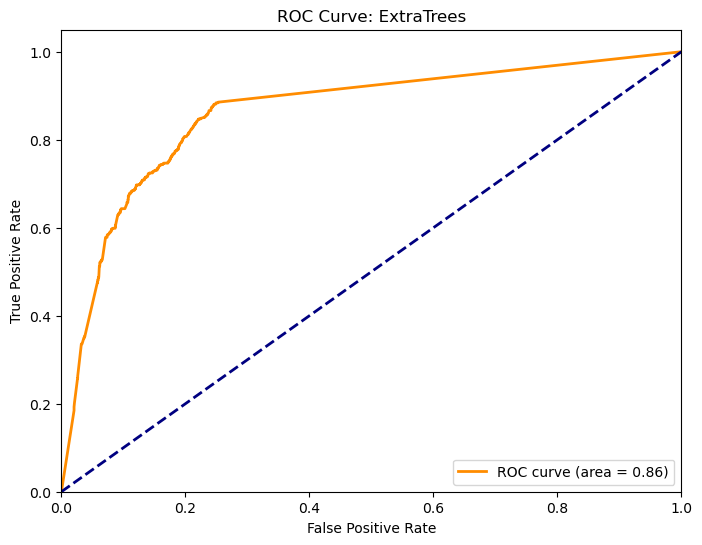

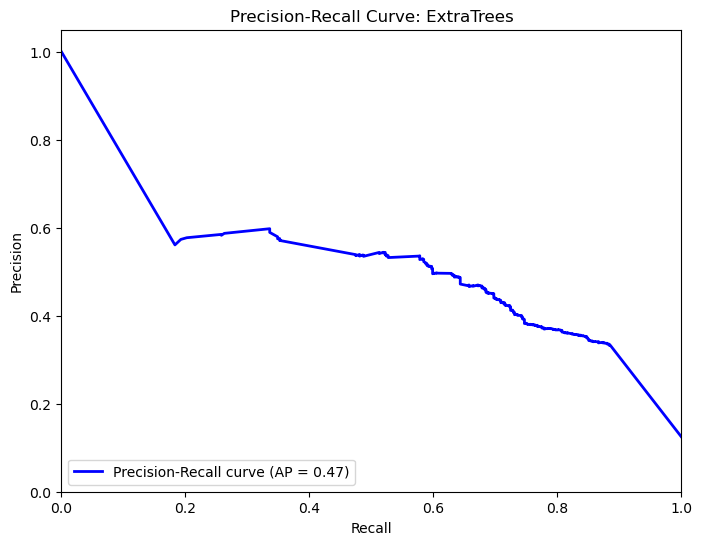

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Example: Plot ROC and PR curves for the best performing model based on F1 score
best_model_name = max(results, key=lambda k: results[k]['f1'])
best_model = best_models[best_model_name]

print(f"Best model by F1 score: {best_model_name} with F1 score = {results[best_model_name]['f1']:.3f}")

# Get predicted probabilities
classes = best_model.classes_
high_risk_idx = np.where(classes == 'High Risk')[0][0]
y_prob = best_model.predict_proba(X_test)[:, high_risk_idx]

# ROC Curve using direct method to avoid versioning issues
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob, pos_label='High Risk')
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: {best_model_name}')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = metrics.precision_recall_curve(y_test, y_prob, pos_label='High Risk')
avg_precision = metrics.average_precision_score(y_test == 'High Risk', y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve: {best_model_name}')
plt.legend(loc="lower left")
plt.show()


C:\Users\wmate\AppData\Local\Temp\ipykernel_36136\444202348.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(f1_scores, vert=False, patch_artist=True, labels=model_names)


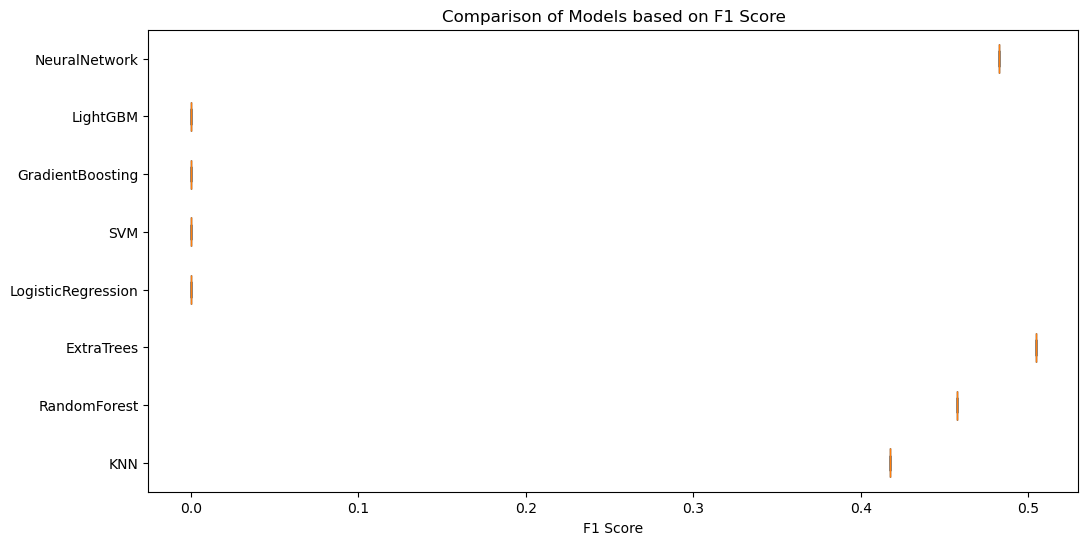

In [25]:
import matplotlib.pyplot as plt

# Extract F1 scores from the results dictionary
model_names = list(results.keys())
f1_scores = [[results[model]['f1']] for model in model_names]  # Wrap each F1 score in a list

# Create a box plot
plt.figure(figsize=(12, 6))
plt.boxplot(f1_scores, vert=False, patch_artist=True, labels=model_names)
plt.xlabel('F1 Score')
plt.title('Comparison of Models based on F1 Score')
plt.show()

<Axes: title={'center': 'Class Distribution'}, xlabel='Risk_Flag'>

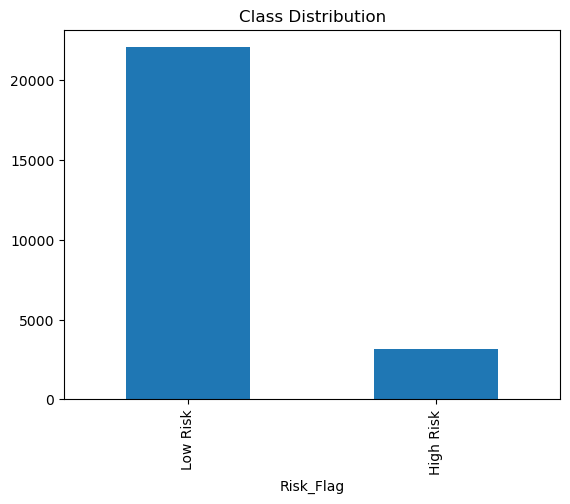

In [28]:
data['Risk_Flag'].value_counts(normalize=False).plot(kind='bar', title='Class Distribution')


In [30]:
import joblib

# Save the best model pipeline
joblib.dump(best_model, 'best_risk_classifier.pkl')


['best_risk_classifier.pkl']